In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the dataset
file_path = r"C:\Users\samia\OneDrive\Documents\GitHub\springboard\Project Proposal\bank+marketing\bank-additional\bank-additional\bank-additional-full.csv"

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
    exit()

bank_additional_full = pd.read_csv(file_path, sep=';')  # Ensure correct separator

# Handle missing values
bank_additional_full.fillna(bank_additional_full.median(numeric_only=True), inplace=True)

# Define target variable
target_column = "y"
if target_column not in bank_additional_full.columns:
    print("Error: Target column not found.")
    exit()

# Convert target to binary
X = bank_additional_full.drop(columns=[target_column])
y = bank_additional_full[target_column].map({'yes': 1, 'no': 0})

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert categorical variables to dummy variables
categorical_columns = X_train.select_dtypes(include=['object']).columns
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Ensure train & test sets have the same features
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]  # Reorder columns to match training set

# Standardize Numeric Features
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Train models and make predictions
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Calculate model performance metrics
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lr)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lr)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lr)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lr)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])
    ]
})

# Print performance table
print(metrics_df)


C:\Users\samia\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:04:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0        Random Forest  0.915878   0.674074  0.490302  0.567686  0.947358
1              XGBoost  0.917456   0.658974  0.553879  0.601874  0.949596
2  Logistic Regression  0.915999   0.708481  0.432112  0.536814  0.942422


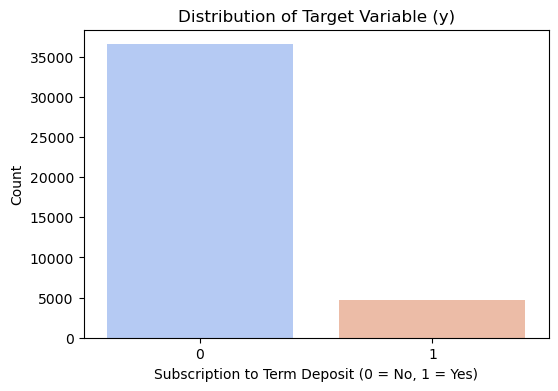

In [5]:
# 1. Distribution of Target Variable
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Distribution of Target Variable (y)")
plt.xlabel("Subscription to Term Deposit (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


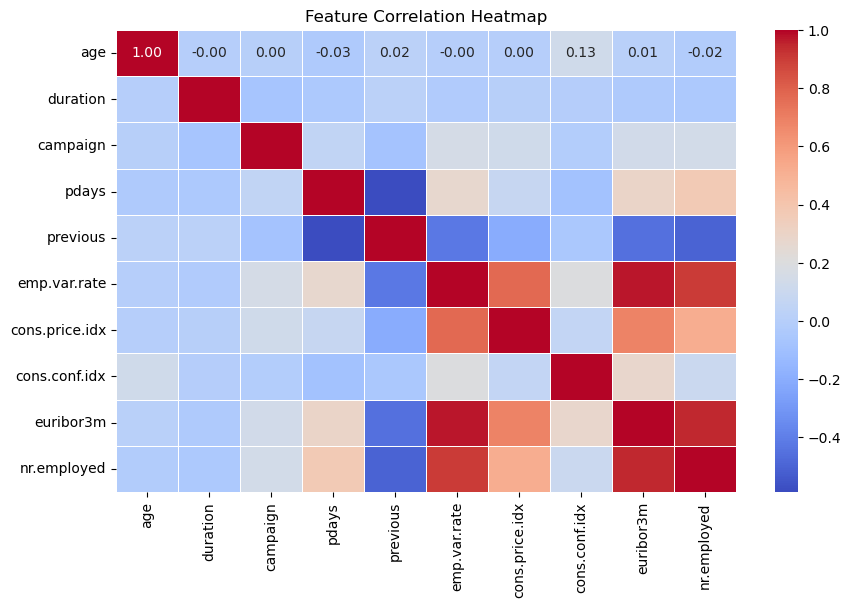

In [7]:
# 2. Correlation Heatmap (Numeric Features)
# Select only numeric columns for correlation calculation
numeric_data = bank_additional_full.select_dtypes(include=['int64', 'float64'])

# 2. Correlation Heatmap (Numeric Features)
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


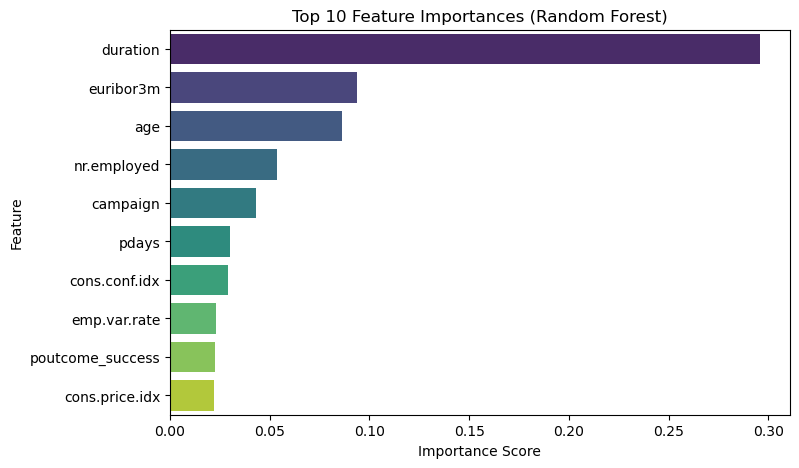

In [8]:
# 3. Feature Importance (Random Forest)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features, y=top_features.index, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()